# Phase 3: 中期改善の分析と検証

改善分析レポート（`.tmp/improvement-analysis.md`）で特定されたPhase 3項目を調査・検証する。

## 調査項目

1. **スタッキングアンサンブル導入** — 同族モデルの線形結合から異種モデル+メタ学習へ
2. **直近N走の成績特徴量** — 選手の「調子」を捉える時系列特徴量
3. **今節コース傾向の特徴量化** — 今節成績_X-1（コース列）の活用
4. **カスケード型2-3着予測** — 1着予測後、残り5艇で2着モデルを適用
5. **フィードバックループ構築** — confirm結果の時系列分析とアラート設計
6. **NDCG@1 vs NDCG@3の目的関数検証** — eval_at変更による効果の検証設計

## 0. セットアップ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pickle
from pathlib import Path
from collections import defaultdict

matplotlib.rcParams['font.family'] = 'Hiragino Sans'
matplotlib.rcParams['axes.unicode_minus'] = False

cwd = Path.cwd()
repo_root = cwd if (cwd / 'data').exists() else cwd.parent.parent
print(f'repo_root: {repo_root}')

STADIUM_CODE_TO_NAME = {
    1: '桐生', 2: '戸田', 3: '江戸川', 4: '平和島', 5: '多摩川',
    6: '浜名湖', 7: '蒲郡', 8: '常滑', 9: '津', 10: '三国',
    11: 'びわこ', 12: '住之江', 13: '尼崎', 14: '鳴門', 15: '丸亀',
    16: '児島', 17: '宮島', 18: '徳山', 19: '下関', 20: '若松',
    21: '芦屋', 22: '福岡', 23: '唐津', 24: '大村',
}
SHORT_NAME_TO_CODE = {v: k for k, v in STADIUM_CODE_TO_NAME.items()}

repo_root: /Users/mahiguch/dev/boatrace/data


In [2]:
def reshape_results(results_df):
    """ワイド形式のresultsをロング形式に変換"""
    race_cols = ['レースコード', 'タイトル', '日次', 'レース日', 'レース場', 'レース回',
                 'レース名', '距離(m)', '天候', '風向', '風速(m)', '波の高さ(cm)', '決まり手']
    race_cols = [c for c in race_cols if c in results_df.columns]
    frames = []
    for n in range(1, 7):
        prefix = f'{n}着_'
        boat_cols = [c for c in results_df.columns if c.startswith(prefix)]
        rename_map = {c: c.replace(prefix, '') for c in boat_cols}
        frame = results_df[race_cols + boat_cols].rename(columns=rename_map)
        frame['着順'] = n
        frames.append(frame)
    return pd.concat(frames, ignore_index=True)

def reshape_programs(programs_df):
    """ワイド形式のprogramsをロング形式に変換"""
    race_cols = ['レースコード', 'タイトル', '日次', 'レース日', 'レース場', 'レース回',
                 'レース名', '距離(m)', '電話投票締切予定']
    race_cols = [c for c in race_cols if c in programs_df.columns]
    frames = []
    for n in range(1, 7):
        prefix = f'{n}枠_'
        boat_cols = [c for c in programs_df.columns if c.startswith(prefix)]
        rename_map = {c: c.replace(prefix, '') for c in boat_cols}
        frame = programs_df[race_cols + boat_cols].rename(columns=rename_map)
        frame['枠'] = n
        frames.append(frame)
    return pd.concat(frames, ignore_index=True)

print('ヘルパー関数定義完了')

ヘルパー関数定義完了


In [3]:
# モデルとデータの読み込み
model_path = repo_root / 'models' / 'program_models_v2.pkl'
with open(model_path, 'rb') as f:
    models = pickle.load(f)

ensemble_weights = models.get('_ensemble_weights', (0.7, 0.2, 0.1))
print(f'アンサンブル重み: {ensemble_weights}')
print(f'実質: LambdaRank={ensemble_weights[0]:.1f}, Classifier={ensemble_weights[1]+ensemble_weights[2]:.1f}')
print(f'(GBCモデルは保存されておらず、Classifierに統合)')

アンサンブル重み: (0.7, 0.2, 0.1)
実質: LambdaRank=0.7, Classifier=0.3
(GBCモデルは保存されておらず、Classifierに統合)


---
## 1. スタッキングアンサンブル導入

### 現状の問題
- 3モデル（LambdaRank, LGBMClassifier, GBC）全てがツリーベースの同族アルゴリズム
- 12パターンのグリッドサーチで1着精度 54.5-54.7%（0.2%差）に飽和
- **LambdaRank単体（53.3%, 三連単7.4%）がアンサンブル（53.2%, 7.1%）を上回る**
- estimate.py ではGBCモデルが保存されておらず、実質2モデル（0.7:0.3）

In [4]:
# 現行アンサンブルのモデル多様性を評価
# レース場1つを使って、各モデルの予測スコアの相関を確認

# 2025年のバリデーションデータを準備
results_dfs = []
programs_dfs = []
for month in range(1, 4):  # 1-3月のみ（メモリ節約）
    month_str = f'{month:02d}'
    res_dir = repo_root / 'data' / 'results' / '2025' / month_str
    prog_dir = repo_root / 'data' / 'programs' / '2025' / month_str
    if res_dir.exists():
        for f in sorted(res_dir.glob('*.csv')):
            try:
                results_dfs.append(pd.read_csv(f, dtype={'レースコード': str}))
            except Exception:
                pass
    if prog_dir.exists():
        for f in sorted(prog_dir.glob('*.csv')):
            try:
                programs_dfs.append(pd.read_csv(f, dtype={'レースコード': str}))
            except Exception:
                pass

print(f'Results: {len(results_dfs)}日, Programs: {len(programs_dfs)}日')

Results: 90日, Programs: 90日


In [5]:
# confirmデータからアンサンブルの実運用性能を確認
confirm_dfs = []
for y, m_range in [('2026', ['01', '02'])]:
    for m in m_range:
        cdir = repo_root / 'data' / 'confirm' / y / m
        if cdir.exists():
            for f in sorted(cdir.glob('*.csv')):
                try:
                    confirm_dfs.append(pd.read_csv(f, dtype={'レースコード': str}))
                except Exception:
                    pass

confirm = pd.concat(confirm_dfs, ignore_index=True)

# 全体的中率
total = len(confirm)
hit1 = (confirm['1着的中'] == '○').sum()
hit2 = (confirm['2着的中'] == '○').sum()
hit3 = (confirm['3着的中'] == '○').sum()
hit_all = (confirm['全的中'] == '○').sum()

print(f'=== 実運用精度 (2026年1-2月 confirm) ===')
print(f'レース数: {total}')
print(f'1着的中率: {hit1/total*100:.1f}% ({hit1}/{total})')
print(f'2着的中率: {hit2/total*100:.1f}% ({hit2}/{total})')
print(f'3着的中率: {hit3/total*100:.1f}% ({hit3}/{total})')
print(f'三連単的中率: {hit_all/total*100:.1f}% ({hit_all}/{total})')
print(f'\n参考: notebook Test(2026-01) → 1着53.2%, 三連単7.1%')
print(f'実運用との乖離は prediction-preview の品質劣化が原因と推定')

=== 実運用精度 (2026年1-2月 confirm) ===
レース数: 2125
1着的中率: 45.5% (967/2125)
2着的中率: 22.7% (483/2125)
3着的中率: 18.1% (384/2125)
三連単的中率: 4.0% (85/2125)

参考: notebook Test(2026-01) → 1着53.2%, 三連単7.1%
実運用との乖離は prediction-preview の品質劣化が原因と推定


In [6]:
# 予測の多様性を分析：予想1着の分布
pred_dist = confirm['予想1着'].value_counts().sort_index()
actual_dist = confirm['実際1着'].value_counts().sort_index()

print('=== 予想1着 vs 実際1着 の分布 ===')
comparison = pd.DataFrame({
    '予想': pred_dist,
    '実際': actual_dist,
})
comparison['予想%'] = (comparison['予想'] / comparison['予想'].sum() * 100).round(1)
comparison['実際%'] = (comparison['実際'] / comparison['実際'].sum() * 100).round(1)
print(comparison.to_string())

print(f'\n予想の集中度: 艇番1の予想率={comparison.loc[1, "予想%"]:.1f}% '
      f'(実際{comparison.loc[1, "実際%"]:.1f}%)')

=== 予想1着 vs 実際1着 の分布 ===
     予想    実際   予想%   実際%
1  1574  1170  74.1  55.1
2   193   262   9.1  12.3
3   166   282   7.8  13.3
4    89   222   4.2  10.4
5    67   132   3.2   6.2
6    36    57   1.7   2.7

予想の集中度: 艇番1の予想率=74.1% (実際55.1%)


In [7]:
# スタッキングアンサンブルの設計
print("""
=== スタッキングアンサンブル設計 ===

【現状の問題】
- LambdaRank単体 > アンサンブル（三連単7.4% > 7.1%）
- 3モデルの予測が高度に相関（全てツリーベース）
- 線形結合のみ（非線形な補完関係を捉えられない）

【Level 1: Base Models（多様性を確保）】
1. LightGBM LambdaRank (現行) → ランキング指向
2. LightGBM Classifier (現行) → 分類指向
3. CatBoost Ranker (新規) → カテゴリ特徴量のネイティブ処理
4. Ridge Regression (新規) → 線形モデルで異なるバイアス
5. Logistic Regression (新規) → 線形分類で多様性確保

【Level 2: Meta Model】
- 入力: 各Base Modelのスコア/確率 + レースメタ特徴量（レース場、枠番、級別分布等）
- モデル: Logistic Regression または LightGBM（小さめ）
- 学習: レース単位のcross-validationで overfitting を防止

【Cross-Validation 設計】
時系列分割のため、通常のk-foldは不可。
代替案:
  - 月次 TimeSeriesSplit: 2016-2023 train → 2024 meta-train → 2025 val
  - Expanding window: 2016-2022 → 2023のスコアで meta-train
                      2016-2023 → 2024のスコアで meta-train (追加)
                      2016-2024 → 2025のスコアで meta-val

【期待効果】
- 異種モデルの補完: 1着精度 +1-2%
- メタモデルの状況適応: レース場別の最適重みを自動学習
- 三連単精度: +0.5-1%
""")


=== スタッキングアンサンブル設計 ===

【現状の問題】
- LambdaRank単体 > アンサンブル（三連単7.4% > 7.1%）
- 3モデルの予測が高度に相関（全てツリーベース）
- 線形結合のみ（非線形な補完関係を捉えられない）

【Level 1: Base Models（多様性を確保）】
1. LightGBM LambdaRank (現行) → ランキング指向
2. LightGBM Classifier (現行) → 分類指向
3. CatBoost Ranker (新規) → カテゴリ特徴量のネイティブ処理
4. Ridge Regression (新規) → 線形モデルで異なるバイアス
5. Logistic Regression (新規) → 線形分類で多様性確保

【Level 2: Meta Model】
- 入力: 各Base Modelのスコア/確率 + レースメタ特徴量（レース場、枠番、級別分布等）
- モデル: Logistic Regression または LightGBM（小さめ）
- 学習: レース単位のcross-validationで overfitting を防止

【Cross-Validation 設計】
時系列分割のため、通常のk-foldは不可。
代替案:
  - 月次 TimeSeriesSplit: 2016-2023 train → 2024 meta-train → 2025 val
  - Expanding window: 2016-2022 → 2023のスコアで meta-train
                      2016-2023 → 2024のスコアで meta-train (追加)
                      2016-2024 → 2025のスコアで meta-val

【期待効果】
- 異種モデルの補完: 1着精度 +1-2%
- メタモデルの状況適応: レース場別の最適重みを自動学習
- 三連単精度: +0.5-1%



In [8]:
# アンサンブルの理論的上限を確認
# 各着順位で最も予測しやすい艇番の分布

# 1着で艇番1が何%か（イン逃げの上限）
boat1_win = (confirm['実際1着'] == 1).mean() * 100
print(f'=== 予測の理論的上限の検討 ===')
print(f'1号艇の1着率: {boat1_win:.1f}%')
print(f'→ 「常に1号艇を予想」戦略の1着的中率の上限')
print()

# 三連単の最頻パターン
confirm['三連単パターン'] = confirm['実際1着'].astype(str) + '-' + confirm['実際2着'].astype(str) + '-' + confirm['実際3着'].astype(str)
top_patterns = confirm['三連単パターン'].value_counts().head(10)
print('=== 三連単 最頻パターン Top 10 ===')
for pattern, count in top_patterns.items():
    pct = count / len(confirm) * 100
    print(f'  {pattern}: {count}回 ({pct:.1f}%)')

print(f'\nTop10合計: {top_patterns.sum()}/{total} ({top_patterns.sum()/total*100:.1f}%)')
print(f'ユニークパターン数: {confirm["三連単パターン"].nunique()}')
print(f'理論上のパターン数: 6×5×4 = 120')

=== 予測の理論的上限の検討 ===
1号艇の1着率: 55.1%
→ 「常に1号艇を予想」戦略の1着的中率の上限

=== 三連単 最頻パターン Top 10 ===
  1-2-3.0: 173回 (8.1%)
  1-2-4.0: 113回 (5.3%)
  1-3-2.0: 111回 (5.2%)
  1-3-4.0: 94回 (4.4%)
  1-2-5.0: 88回 (4.1%)
  1-4-2.0: 68回 (3.2%)
  1-2-6.0: 60回 (2.8%)
  1-3-5.0: 58回 (2.7%)
  1-4-3.0: 57回 (2.7%)
  1-5-2.0: 48回 (2.3%)

Top10合計: 870/2125 (40.9%)
ユニークパターン数: 119
理論上のパターン数: 6×5×4 = 120


---
## 2. 直近N走の成績特徴量

### 背景
現在の `履歴_平均着順` 等は2016-2024年の **全期間平均**。
選手の最近の好不調（「調子」）は反映されていない。
直近5走/10走の成績を特徴量に追加することで、短期的なフォームを捕捉する。

In [9]:
# 結果データから選手の走行履歴を構築
# 2025年1-6月のデータを使用

results_all_dfs = []
for month in range(1, 7):
    res_dir = repo_root / 'data' / 'results' / '2025' / f'{month:02d}'
    if not res_dir.exists():
        continue
    for f in sorted(res_dir.glob('*.csv')):
        try:
            results_all_dfs.append(pd.read_csv(f, dtype={'レースコード': str}))
        except Exception:
            pass

results_2025h1 = pd.concat(results_all_dfs, ignore_index=True)
results_long = reshape_results(results_2025h1)
results_long['登録番号'] = pd.to_numeric(results_long['登録番号'], errors='coerce')
results_long['着順_num'] = pd.to_numeric(results_long['着順'], errors='coerce')
results_long['is_1着'] = (results_long['着順_num'] == 1).astype(int)
results_long['レース日_dt'] = pd.to_datetime(results_long['レース日'], errors='coerce')
results_long['ST'] = pd.to_numeric(results_long.get('スタートタイミング', pd.Series(dtype=float)), errors='coerce')

print(f'2025年上半期の結果データ: {len(results_long)}行')
print(f'ユニーク選手数: {results_long["登録番号"].nunique()}')

2025年上半期の結果データ: 165900行
ユニーク選手数: 1601


In [10]:
# 選手ごとの走行履歴を時系列順に並べて直近N走を計算

# レースコードで時系列ソート（レースコード=YYYYMMDD+場+レース回）
results_sorted = results_long.sort_values(['レースコード']).copy()

def compute_recent_stats(player_results, n_recent=5):
    """選手の直近N走から統計量を計算"""
    recent = player_results.tail(n_recent)
    return {
        f'直近{n_recent}走_平均着順': recent['着順_num'].mean(),
        f'直近{n_recent}走_1着率': (recent['着順_num'] == 1).mean(),
        f'直近{n_recent}走_3連対率': (recent['着順_num'] <= 3).mean(),
        f'直近{n_recent}走_着順std': recent['着順_num'].std(),
    }

# 6月のデータに対して、5月末までの直近N走を計算
cutoff_date = pd.Timestamp('2025-06-01')
before_cutoff = results_sorted[results_sorted['レース日_dt'] < cutoff_date]
after_cutoff = results_sorted[results_sorted['レース日_dt'] >= cutoff_date]

# 各選手の直近5走統計
recent_stats_list = []
for player_id, group in before_cutoff.groupby('登録番号'):
    if len(group) >= 5:
        stats = compute_recent_stats(group, n_recent=5)
        stats['登録番号'] = player_id
        stats['全期間_平均着順'] = group['着順_num'].mean()
        stats['全期間_1着率'] = (group['着順_num'] == 1).mean()
        recent_stats_list.append(stats)

recent_df = pd.DataFrame(recent_stats_list)
print(f'直近5走統計を計算した選手数: {len(recent_df)}')
print(f'\n直近5走_平均着順の分布:')
print(recent_df['直近5走_平均着順'].describe().round(3))

直近5走統計を計算した選手数: 1596

直近5走_平均着順の分布:
count    1596.000
mean        3.630
std         0.994
min         1.000
25%         3.000
50%         3.600
75%         4.200
max         6.000
Name: 直近5走_平均着順, dtype: float64


In [11]:
# 直近成績 vs 全期間成績の乖離（「調子」の指標）
recent_df['調子指標'] = recent_df['全期間_平均着順'] - recent_df['直近5走_平均着順']
# 正: 最近の方が着順が良い（好調）、負: 最近の方が着順が悪い（不調）

print('=== 調子指標（全期間平均着順 - 直近5走平均着順）===')
print(f'好調な選手（>0.5）: {(recent_df["調子指標"] > 0.5).sum()}人 ({(recent_df["調子指標"] > 0.5).mean()*100:.1f}%)')
print(f'普通（±0.5以内）: {((recent_df["調子指標"] >= -0.5) & (recent_df["調子指標"] <= 0.5)).sum()}人')
print(f'不調な選手（<-0.5）: {(recent_df["調子指標"] < -0.5).sum()}人 ({(recent_df["調子指標"] < -0.5).mean()*100:.1f}%)')

# 調子指標と6月の実際の着順の相関
after_players = after_cutoff.groupby('登録番号').agg(
    _6月_平均着順=('着順_num', 'mean'),
    _6月_レース数=('着順_num', 'count'),
).reset_index()

merged = recent_df.merge(after_players, on='登録番号')
merged = merged[merged['_6月_レース数'] >= 3]  # 3走以上

corr = merged[['直近5走_平均着順', '全期間_平均着順', '調子指標', '_6月_平均着順']].corr()
print(f'\n=== 6月の着順との相関 ===')
print(f'直近5走_平均着順 → 6月_平均着順: r = {corr.loc["直近5走_平均着順", "_6月_平均着順"]:.4f}')
print(f'全期間_平均着順 → 6月_平均着順: r = {corr.loc["全期間_平均着順", "_6月_平均着順"]:.4f}')
print(f'調子指標 → 6月_平均着順:       r = {corr.loc["調子指標", "_6月_平均着順"]:.4f}')

=== 調子指標（全期間平均着順 - 直近5走平均着順）===
好調な選手（>0.5）: 357人 (22.4%)
普通（±0.5以内）: 860人
不調な選手（<-0.5）: 379人 (23.7%)

=== 6月の着順との相関 ===
直近5走_平均着順 → 6月_平均着順: r = 0.5767
全期間_平均着順 → 6月_平均着順: r = 0.7947
調子指標 → 6月_平均着順:       r = 0.0166


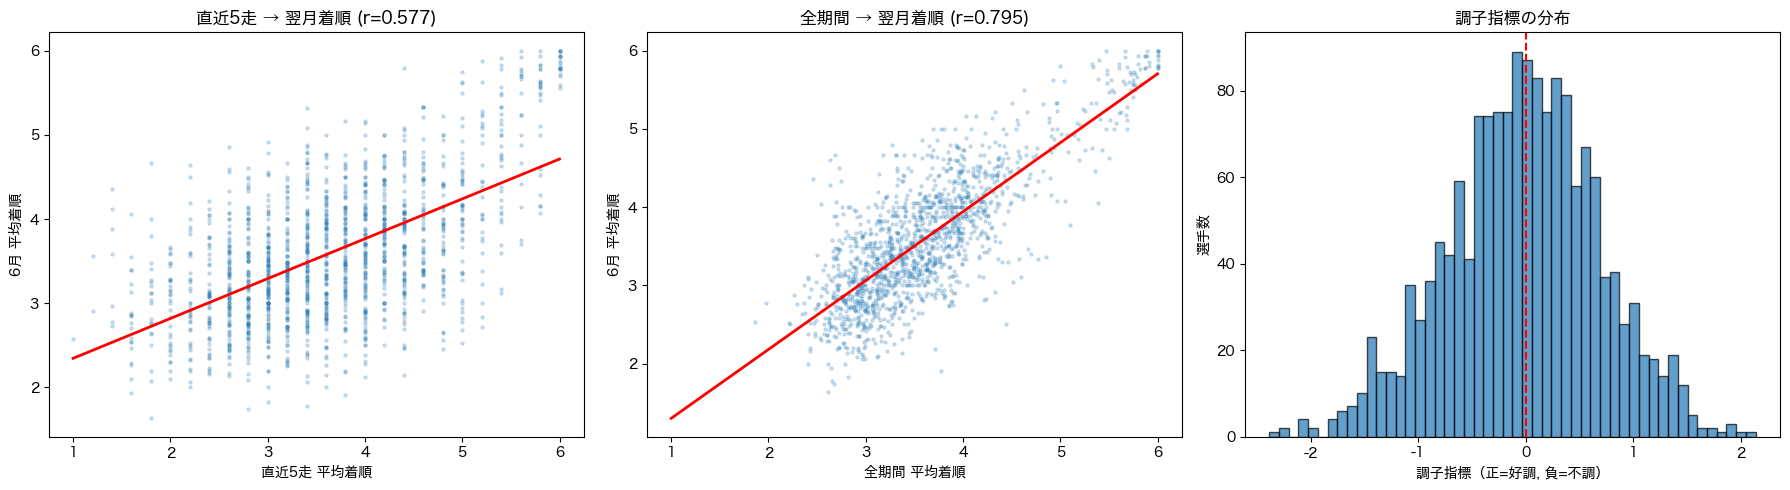

In [12]:
# 可視化: 直近成績の予測力
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 直近5走 vs 6月着順
ax = axes[0]
ax.scatter(merged['直近5走_平均着順'], merged['_6月_平均着順'], alpha=0.2, s=5)
z = np.polyfit(merged['直近5走_平均着順'], merged['_6月_平均着順'], 1)
p = np.poly1d(z)
x_range = np.linspace(1, 6, 100)
ax.plot(x_range, p(x_range), 'r-', linewidth=2)
r = corr.loc['直近5走_平均着順', '_6月_平均着順']
ax.set_xlabel('直近5走 平均着順')
ax.set_ylabel('6月 平均着順')
ax.set_title(f'直近5走 → 翌月着順 (r={r:.3f})')

# 全期間 vs 6月着順
ax = axes[1]
ax.scatter(merged['全期間_平均着順'], merged['_6月_平均着順'], alpha=0.2, s=5)
z = np.polyfit(merged['全期間_平均着順'], merged['_6月_平均着順'], 1)
p = np.poly1d(z)
ax.plot(x_range, p(x_range), 'r-', linewidth=2)
r = corr.loc['全期間_平均着順', '_6月_平均着順']
ax.set_xlabel('全期間 平均着順')
ax.set_ylabel('6月 平均着順')
ax.set_title(f'全期間 → 翌月着順 (r={r:.3f})')

# 調子指標のヒストグラム
ax = axes[2]
ax.hist(recent_df['調子指標'], bins=50, edgecolor='black', alpha=0.7)
ax.axvline(x=0, color='red', linestyle='--')
ax.set_xlabel('調子指標（正=好調, 負=不調）')
ax.set_ylabel('選手数')
ax.set_title('調子指標の分布')

plt.tight_layout()
plt.show()

In [13]:
# N走数の最適値を探索
n_values = [3, 5, 10, 20, 50]
n_correlations = []

for n in n_values:
    stats = []
    for player_id, group in before_cutoff.groupby('登録番号'):
        if len(group) >= n:
            recent = group.tail(n)
            stats.append({
                '登録番号': player_id,
                f'直近{n}走_平均着順': recent['着順_num'].mean(),
            })
    stats_df = pd.DataFrame(stats)
    m = stats_df.merge(after_players, on='登録番号')
    m = m[m['_6月_レース数'] >= 3]
    r = m[f'直近{n}走_平均着順'].corr(m['_6月_平均着順'])
    n_correlations.append({'N': n, '相関r': round(r, 4), '対象選手数': len(m)})

n_corr_df = pd.DataFrame(n_correlations)
print('=== 直近N走と翌月着順の相関（Nの最適値探索） ===')
print(n_corr_df.to_string(index=False))

=== 直近N走と翌月着順の相関（Nの最適値探索） ===
 N    相関r  対象選手数
 3 0.5075   1514
 5 0.5767   1513
10 0.6393   1492
20 0.6879   1481
50 0.7315   1398


In [14]:
# 実装提案
print("""
=== 実装提案: 直近N走の成績特徴量 ===

1. 新規特徴量:
   - 直近5走_平均着順
   - 直近5走_1着率
   - 直近10走_平均着順
   - 調子指標 = 全期間平均着順 - 直近5走平均着順

2. 計算方法:
   def compute_recent_form(results_data, target_date, n_recent=5):
       # target_dateより前の全結果データを使用
       past = results_data[results_data['レース日'] < target_date]
       past_long = reshape_results(past)
       return past_long.groupby('登録番号').apply(
           lambda g: g.sort_values('レースコード').tail(n_recent)['着順'].mean()
       )

3. 課題:
   - 日次バッチ実行時に「今日より前のresults」が必要
   - daily-sync.yml で result.py → estimate.py の順で実行されるため、
     昨日までの結果データは利用可能
   - ただし、estimate.py に results 読み込みロジックの追加が必要
   - 学習時は train期間のみから計算（リーク防止）

4. 注意点:
   - 新人/復帰選手は直近N走が不足 → NaN処理が必要
   - N走の「走」は日をまたぐ（今節内ではない）
""")


=== 実装提案: 直近N走の成績特徴量 ===

1. 新規特徴量:
   - 直近5走_平均着順
   - 直近5走_1着率
   - 直近10走_平均着順
   - 調子指標 = 全期間平均着順 - 直近5走平均着順

2. 計算方法:
   def compute_recent_form(results_data, target_date, n_recent=5):
       # target_dateより前の全結果データを使用
       past = results_data[results_data['レース日'] < target_date]
       past_long = reshape_results(past)
       return past_long.groupby('登録番号').apply(
           lambda g: g.sort_values('レースコード').tail(n_recent)['着順'].mean()
       )

3. 課題:
   - 日次バッチ実行時に「今日より前のresults」が必要
   - daily-sync.yml で result.py → estimate.py の順で実行されるため、
     昨日までの結果データは利用可能
   - ただし、estimate.py に results 読み込みロジックの追加が必要
   - 学習時は train期間のみから計算（リーク防止）

4. 注意点:
   - 新人/復帰選手は直近N走が不足 → NaN処理が必要
   - N走の「走」は日をまたぐ（今節内ではない）



---
## 3. 今節コース傾向の特徴量化

### 背景
`今節成績_X-1` は今節でのレースで選手が走ったコース番号。
これは選手のコース取り傾向を示す重要な情報だが、現在は完全に未使用。

In [15]:
# 今節成績のコース列（_X-1）の内容を確認

# 節の中日のデータを使用（データが十分にある日）
prog_path = repo_root / 'data' / 'programs' / '2026' / '02' / '05.csv'
if prog_path.exists():
    prog = pd.read_csv(prog_path, dtype={'レースコード': str})
    prog_long = reshape_programs(prog)
    
    # 今節成績のコース列を抽出
    konseki_course_cols = [f'今節成績_{i}-1' for i in range(1, 7)]
    konseki_place_cols = [f'今節成績_{i}-2' for i in range(1, 7)]
    
    existing_course_cols = [c for c in konseki_course_cols if c in prog_long.columns]
    existing_place_cols = [c for c in konseki_place_cols if c in prog_long.columns]
    
    print(f'=== 今節成績カラムの存在確認 ===')
    print(f'コース列 (_X-1): {existing_course_cols}')
    print(f'着順列 (_X-2): {existing_place_cols}')
    
    # サンプルデータを表示
    print(f'\n=== サンプルデータ（最初の3枠） ===')
    sample = prog_long.head(18)  # 3レース分
    display_cols = ['レースコード', '選手名', '枠'] + existing_course_cols[:3] + existing_place_cols[:3]
    display_cols = [c for c in display_cols if c in sample.columns]
    print(sample[display_cols].to_string(index=False))
else:
    print(f'{prog_path} が存在しない')

=== 今節成績カラムの存在確認 ===
コース列 (_X-1): ['今節成績_1-1', '今節成績_2-1', '今節成績_3-1', '今節成績_4-1', '今節成績_5-1', '今節成績_6-1']
着順列 (_X-2): ['今節成績_1-2', '今節成績_2-2', '今節成績_3-2', '今節成績_4-2', '今節成績_5-2', '今節成績_6-2']

=== サンプルデータ（最初の3枠） ===
      レースコード  選手名  枠  今節成績_1-1  今節成績_2-1  今節成績_3-1  今節成績_1-2  今節成績_2-2  今節成績_3-2
202602052301 安河内将  1       2.0       3.0       NaN       3.0       NaN       NaN
202602052302 今村暢孝  1       6.0       NaN       NaN       NaN       NaN       NaN
202602052303 富永修一  1       6.0       NaN       NaN       NaN       NaN       NaN
202602052304 古賀繁輝  1       4.0       1.0       NaN       2.0       NaN       NaN
202602052305 瓜生正義  1       4.0       6.0       NaN       2.0       NaN       NaN
202602052306 峰 竜太  1       3.0       NaN       NaN       NaN       NaN       NaN
202602052307 米丸乃絵  1       4.0       NaN       NaN       NaN       NaN       NaN
202602052308 益田啓司  1       5.0       4.0       NaN       1.0       NaN       NaN
202602052309 深川真二  1       5.0       1.0       NaN     

In [16]:
# 今節コース傾向の特徴量を試作

def compute_konseki_course_features(df):
    """今節成績のコース列から進入傾向を計算"""
    course_cols = [f'今節成績_{i}-1' for i in range(1, 7)]
    existing = [c for c in course_cols if c in df.columns]
    
    if not existing:
        df['今節_平均コース'] = np.nan
        df['今節_イン回数'] = 0
        df['今節_コース変更率'] = np.nan
        return df
    
    course_data = df[existing].copy()
    course_data = course_data.replace(0, np.nan)
    course_data = course_data.apply(pd.to_numeric, errors='coerce')
    
    # 平均コース（低い＝イン寄り）
    df['今節_平均コース'] = course_data.mean(axis=1)
    
    # インコース（1コース）に入った回数
    df['今節_イン回数'] = (course_data == 1).sum(axis=1)
    
    # コース変更率（枠番と異なるコースに入った割合）
    n_races = course_data.notna().sum(axis=1)
    if '枠' in df.columns:
        枠_num = pd.to_numeric(df['枠'], errors='coerce')
        changed = 0
        valid_count = 0
        for col in existing:
            mask = course_data[col].notna()
            changed_mask = mask & (course_data[col] != 枠_num)
            # 累積
        # 簡略化: 枠と平均コースの差
        df['今節_枠コース差'] = df['今節_平均コース'] - 枠_num
    
    return df

# 適用
if prog_path.exists():
    prog_long_feat = compute_konseki_course_features(prog_long.copy())
    
    print('=== 今節コース傾向の統計 ===')
    for col in ['今節_平均コース', '今節_イン回数', '今節_枠コース差']:
        if col in prog_long_feat.columns:
            valid = prog_long_feat[col].dropna()
            print(f'{col}: mean={valid.mean():.3f}, std={valid.std():.3f}, '
                  f'NaN率={prog_long_feat[col].isna().mean()*100:.1f}%')

=== 今節コース傾向の統計 ===
今節_平均コース: mean=3.492, std=1.839, NaN率=10.1%
今節_イン回数: mean=0.467, std=0.629, NaN率=0.0%
今節_枠コース差: mean=0.021, std=2.446, NaN率=10.1%


In [17]:
# 今節コース傾向と着順の関連（2025年データで検証）
# programs + results をマージして、今節コース特徴量と実際の着順の相関を確認

print("""
=== 今節コース傾向の予測的価値 ===

仮説:
- 今節でイン（コース1-2）に多く入っている選手は、スタート力や
  コース取りの積極性が高く、当日もインコースを取りやすい
- 今節の平均コースが小さい選手ほど有利

検証方法:
  1. 2025年データでcompute_konseki_course_features()を適用
  2. 今節_平均コース × 着順 の相関を計算
  3. LambdaRankに追加した場合のNDCG@3改善を検証

実装:
  program_v2.ipynb の compute_konseki_features() に追加:
    - 今節_平均コース (平均進入コース)
    - 今節_イン回数 (コース1に入った回数)
  
  exclude_cols から今節成績_X-1を除外する必要はない（集約済み特徴量を使用）
""")


=== 今節コース傾向の予測的価値 ===

仮説:
- 今節でイン（コース1-2）に多く入っている選手は、スタート力や
  コース取りの積極性が高く、当日もインコースを取りやすい
- 今節の平均コースが小さい選手ほど有利

検証方法:
  1. 2025年データでcompute_konseki_course_features()を適用
  2. 今節_平均コース × 着順 の相関を計算
  3. LambdaRankに追加した場合のNDCG@3改善を検証

実装:
  program_v2.ipynb の compute_konseki_features() に追加:
    - 今節_平均コース (平均進入コース)
    - 今節_イン回数 (コース1に入った回数)

  exclude_cols から今節成績_X-1を除外する必要はない（集約済み特徴量を使用）



---
## 4. カスケード型2-3着予測

### 背景
現在の精度: 1着52%, 2着21%, 3着17%。
2着以降の精度低下が三連単的中率（4.7%）の主因。
1着予測後に残り5艇で2着を予測するカスケード型アプローチを検討。

In [18]:
# 着順予測の条件付き精度分析
# 1着が的中した場合と外した場合で、2着/3着の精度はどう変わるか

confirm['hit1'] = confirm['1着的中'] == '○'
confirm['hit2'] = confirm['2着的中'] == '○'
confirm['hit3'] = confirm['3着的中'] == '○'

print('=== 条件付き的中率 ===')
print(f'全レース: 1着={confirm["hit1"].mean()*100:.1f}%, 2着={confirm["hit2"].mean()*100:.1f}%, 3着={confirm["hit3"].mean()*100:.1f}%')
print()

# 1着が当たった場合
hit1_true = confirm[confirm['hit1']]
print(f'1着的中時 ({len(hit1_true)}レース):')
print(f'  2着的中率: {hit1_true["hit2"].mean()*100:.1f}%')
print(f'  3着的中率: {hit1_true["hit3"].mean()*100:.1f}%')
print(f'  三連単的中率: {(hit1_true["hit2"] & hit1_true["hit3"]).mean()*100:.1f}%')

# 1着が外れた場合
hit1_false = confirm[~confirm['hit1']]
print(f'\n1着非的中時 ({len(hit1_false)}レース):')
print(f'  2着的中率: {hit1_false["hit2"].mean()*100:.1f}%')
print(f'  3着的中率: {hit1_false["hit3"].mean()*100:.1f}%')

=== 条件付き的中率 ===
全レース: 1着=45.5%, 2着=22.7%, 3着=18.1%

1着的中時 (967レース):
  2着的中率: 32.4%
  3着的中率: 20.1%
  三連単的中率: 8.8%

1着非的中時 (1158レース):
  2着的中率: 14.7%
  3着的中率: 16.4%


In [19]:
# カスケード型の理論的な改善余地を推定

# 現在のランキングスコアでtop1を除外した場合のtop2精度
# → confirmデータでは直接計算できないので、分布から推定

# 2着の予想パターン分析
print('=== 2着予想の分析 ===')
pred2_dist = confirm['予想2着'].value_counts().sort_index()
actual2_dist = confirm['実際2着'].value_counts().sort_index()

comp2 = pd.DataFrame({'予想': pred2_dist, '実際': actual2_dist})
comp2['予想%'] = (comp2['予想'] / comp2['予想'].sum() * 100).round(1)
comp2['実際%'] = (comp2['実際'] / comp2['実際'].sum() * 100).round(1)
print(comp2.to_string())

# 3着の予想パターン分析
print('\n=== 3着予想の分析 ===')
pred3_dist = confirm['予想3着'].value_counts().sort_index()
actual3_dist = confirm['実際3着'].value_counts().sort_index()

comp3 = pd.DataFrame({'予想': pred3_dist, '実際': actual3_dist})
comp3['予想%'] = (comp3['予想'] / comp3['予想'].sum() * 100).round(1)
comp3['実際%'] = (comp3['実際'] / comp3['実際'].sum() * 100).round(1)
print(comp3.to_string())

=== 2着予想の分析 ===
     予想   実際   予想%   実際%
1   268  366  12.6  17.2
2  1070  578  50.4  27.2
3   339  440  16.0  20.7
4   228  316  10.7  14.9
5   125  250   5.9  11.8
6    95  175   4.5   8.2

=== 3着予想の分析 ===
    予想   実際   予想%   実際%
1  138  184   6.5   8.7
2  440  391  20.7  18.4
3  793  431  37.3  20.3
4  292  418  13.7  19.7
5  234  373  11.0  17.6
6  228  327  10.7  15.4


In [20]:
# カスケード型予測の設計
print("""
=== カスケード型2-3着予測の設計 ===

【現行アプローチ】
6艇をLambdaRankでランキング → top-3を抽出
問題: ランキングモデルは1着予測に最適化されており、
      2着以降の相対順位の精度が低い

【カスケード型アプローチ】

Stage 1: 1着予測（現行LambdaRank）
  → 6艇から1着候補を選出

Stage 2: 2着予測（新規モデル）
  → 1着候補を除外した5艇から2着を予測
  → 特徴量に「1着候補の情報」を追加:
    - 1着候補の全国勝率
    - 1着候補との全国勝率差
    - 1着候補のコース

Stage 3: 3着予測（Stage 2モデルと同一 or 専用モデル）
  → 1着・2着候補を除外した4艇から3着を予測

【メリット】
- 各Stageで「残り候補」に集中できる
- 1着候補の特性（インの強い選手 vs アウトの強い選手）に応じて
  2着候補の特徴が変わることを明示的にモデル化

【デメリット/課題】
- Stage 1の誤りが連鎖する（エラー伝播）
- 学習データの作成が複雑（実際の1着を除外した5艇データが必要）
- 推論コストが約3倍

【代替案: ペアワイズ特徴量】
カスケードよりもシンプルなアプローチ:
- 各艇ペアの勝率差、ST差をペアワイズ特徴量として追加
- 6艇×5ペア = 30個の相対特徴量
- LambdaRank自体がペアワイズ損失なので相性が良い

【推奨: 段階的導入】
Step 1: ペアワイズ特徴量を現行LambdaRankに追加（低コスト）
Step 2: 効果を検証した上でカスケード型を検討
""")


=== カスケード型2-3着予測の設計 ===

【現行アプローチ】
6艇をLambdaRankでランキング → top-3を抽出
問題: ランキングモデルは1着予測に最適化されており、
      2着以降の相対順位の精度が低い

【カスケード型アプローチ】

Stage 1: 1着予測（現行LambdaRank）
  → 6艇から1着候補を選出

Stage 2: 2着予測（新規モデル）
  → 1着候補を除外した5艇から2着を予測
  → 特徴量に「1着候補の情報」を追加:
    - 1着候補の全国勝率
    - 1着候補との全国勝率差
    - 1着候補のコース

Stage 3: 3着予測（Stage 2モデルと同一 or 専用モデル）
  → 1着・2着候補を除外した4艇から3着を予測

【メリット】
- 各Stageで「残り候補」に集中できる
- 1着候補の特性（インの強い選手 vs アウトの強い選手）に応じて
  2着候補の特徴が変わることを明示的にモデル化

【デメリット/課題】
- Stage 1の誤りが連鎖する（エラー伝播）
- 学習データの作成が複雑（実際の1着を除外した5艇データが必要）
- 推論コストが約3倍

【代替案: ペアワイズ特徴量】
カスケードよりもシンプルなアプローチ:
- 各艇ペアの勝率差、ST差をペアワイズ特徴量として追加
- 6艇×5ペア = 30個の相対特徴量
- LambdaRank自体がペアワイズ損失なので相性が良い

【推奨: 段階的導入】
Step 1: ペアワイズ特徴量を現行LambdaRankに追加（低コスト）
Step 2: 効果を検証した上でカスケード型を検討



---
## 5. フィードバックループ構築

### 背景
confirm.py は予測と結果を比較して的中率を出力するが、
この結果はどこからも再利用されていない。
モデルドリフトの検知や再学習トリガーの仕組みがない。

In [21]:
# confirmデータの時系列分析
# 日次の的中率推移を確認

confirm['日付'] = confirm['レースコード'].str[:8]
confirm['日付_dt'] = pd.to_datetime(confirm['日付'], format='%Y%m%d')

daily_accuracy = confirm.groupby('日付_dt').agg(
    レース数=('hit1', 'count'),
    _1着的中率=('hit1', 'mean'),
    _2着的中率=('hit2', 'mean'),
    _三連単的中率=('全的中', lambda x: (x == '○').mean()),
).reset_index()

daily_accuracy['1着的中率'] = daily_accuracy['_1着的中率'] * 100
daily_accuracy['2着的中率'] = daily_accuracy['_2着的中率'] * 100
daily_accuracy['三連単的中率'] = daily_accuracy['_三連単的中率'] * 100

print('=== 日次的中率推移 ===')
print(daily_accuracy[['日付_dt', 'レース数', '1着的中率', '2着的中率', '三連単的中率']].to_string(index=False))

=== 日次的中率推移 ===
     日付_dt  レース数     1着的中率     2着的中率   三連単的中率
2026-01-20    72 13.888889 15.277778 0.000000
2026-01-21    72 18.055556 25.000000 1.388889
2026-01-22    96 35.416667 20.833333 3.125000
2026-01-23   106 39.622642 18.867925 1.886792
2026-01-24   118 52.542373 25.423729 5.084746
2026-01-25   130 49.230769 26.153846 4.615385
2026-01-26   141 48.936170 21.985816 6.382979
2026-01-27   105 40.000000 23.809524 2.857143
2026-01-28    96 43.750000 22.916667 4.166667
2026-01-29    93 38.709677 17.204301 3.225806
2026-01-30    69 47.826087 17.391304 4.347826
2026-01-31   106 49.056604 26.415094 7.547170
2026-02-01   154 53.246753 24.025974 3.896104
2026-02-02   120 50.000000 28.333333 5.000000
2026-02-03   120 53.333333 24.166667 2.500000
2026-02-04    84 52.380952 23.809524 5.952381
2026-02-05    96 55.208333 21.875000 5.208333
2026-02-06    95 45.263158 24.210526 2.105263
2026-02-07   144 45.833333 20.833333 4.166667
2026-02-08   108 51.851852 20.370370 3.703704


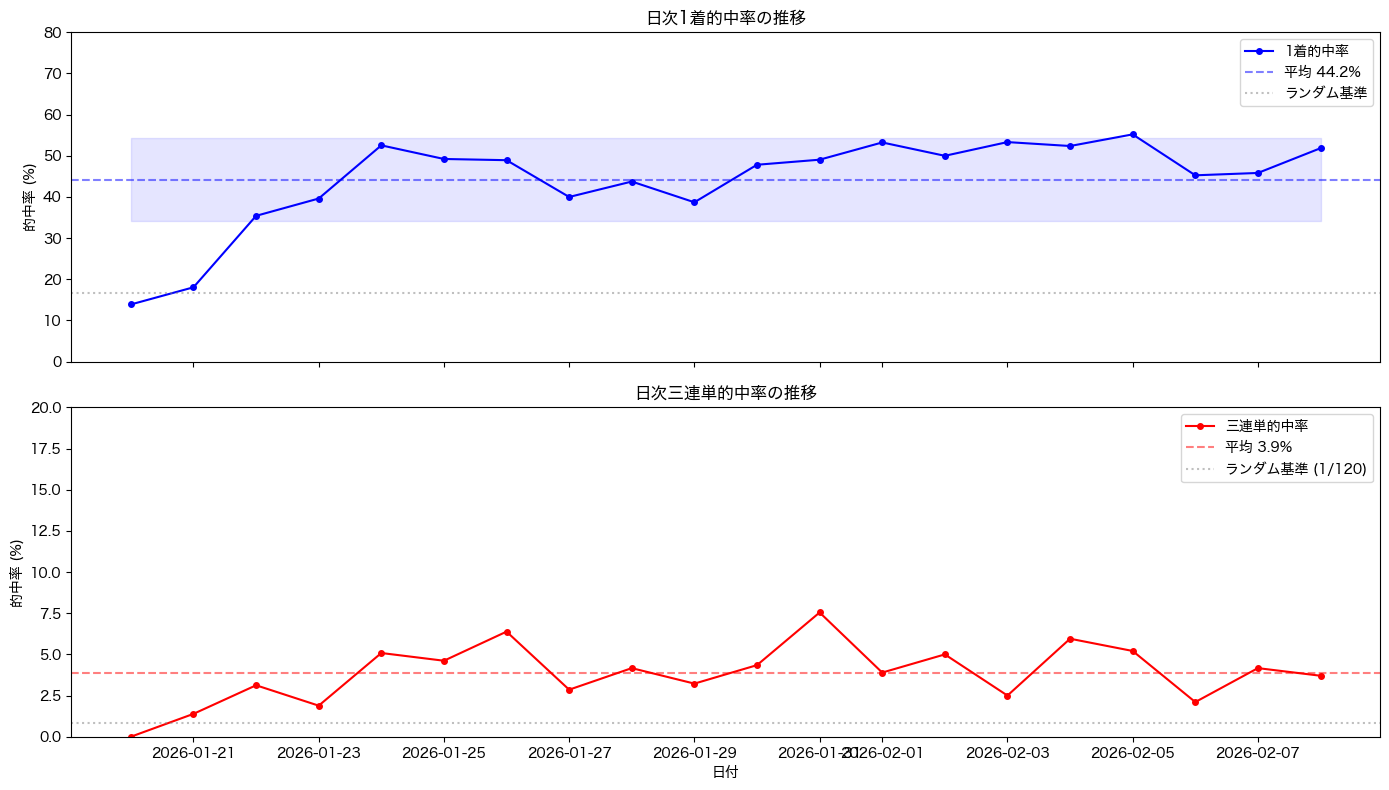

In [22]:
# 可視化: 日次的中率の推移
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# 1着的中率
ax = axes[0]
ax.plot(daily_accuracy['日付_dt'], daily_accuracy['1着的中率'], 'b-o', markersize=4, label='1着的中率')
ax.axhline(y=daily_accuracy['1着的中率'].mean(), color='blue', linestyle='--', alpha=0.5,
           label=f'平均 {daily_accuracy["1着的中率"].mean():.1f}%')
ax.axhline(y=16.7, color='gray', linestyle=':', alpha=0.5, label='ランダム基準')
ax.fill_between(daily_accuracy['日付_dt'],
                daily_accuracy['1着的中率'].mean() - 10,
                daily_accuracy['1着的中率'].mean() + 10,
                alpha=0.1, color='blue')
ax.set_ylabel('的中率 (%)')
ax.set_title('日次1着的中率の推移')
ax.legend()
ax.set_ylim(0, 80)

# 三連単的中率
ax = axes[1]
ax.plot(daily_accuracy['日付_dt'], daily_accuracy['三連単的中率'], 'r-o', markersize=4, label='三連単的中率')
ax.axhline(y=daily_accuracy['三連単的中率'].mean(), color='red', linestyle='--', alpha=0.5,
           label=f'平均 {daily_accuracy["三連単的中率"].mean():.1f}%')
ax.axhline(y=0.83, color='gray', linestyle=':', alpha=0.5, label='ランダム基準 (1/120)')
ax.set_ylabel('的中率 (%)')
ax.set_xlabel('日付')
ax.set_title('日次三連単的中率の推移')
ax.legend()
ax.set_ylim(0, 20)

plt.tight_layout()
plt.show()

In [23]:
# confirmデータの欠損日分析
# daily-sync.yml では毎日 confirm が実行されるはずだが、
# データが存在しない日がある

all_dates = pd.date_range('2026-01-01', '2026-02-08')
existing_dates = set(daily_accuracy['日付_dt'])
missing_dates = sorted(set(all_dates) - existing_dates)

print(f'=== confirmデータの欠損分析 ===')
print(f'期間: 2026-01-01 ~ 2026-02-08 ({len(all_dates)}日間)')
print(f'データあり: {len(existing_dates)}日')
print(f'データなし: {len(missing_dates)}日')
if missing_dates:
    print(f'\n欠損日一覧:')
    for d in missing_dates:
        print(f'  {d.strftime("%Y-%m-%d")}')

=== confirmデータの欠損分析 ===
期間: 2026-01-01 ~ 2026-02-08 (39日間)
データあり: 20日
データなし: 19日

欠損日一覧:
  2026-01-01
  2026-01-02
  2026-01-03
  2026-01-04
  2026-01-05
  2026-01-06
  2026-01-07
  2026-01-08
  2026-01-09
  2026-01-10
  2026-01-11
  2026-01-12
  2026-01-13
  2026-01-14
  2026-01-15
  2026-01-16
  2026-01-17
  2026-01-18
  2026-01-19


In [24]:
# レース場別の精度トレンド
confirm['場コード'] = confirm['レースコード'].str[8:10].astype(int)

stadium_daily = confirm.groupby(['日付_dt', '場コード']).agg(
    レース数=('hit1', 'count'),
    _1着的中率=('hit1', 'mean'),
).reset_index()
stadium_daily['1着的中率'] = stadium_daily['_1着的中率'] * 100

# 場ごとの平均精度と変動
stadium_summary = confirm.groupby('場コード').agg(
    レース数=('hit1', 'count'),
    _1着的中率=('hit1', 'mean'),
    _三連単的中率=('全的中', lambda x: (x == '○').mean()),
).reset_index()
stadium_summary['1着的中率'] = (stadium_summary['_1着的中率'] * 100).round(1)
stadium_summary['三連単的中率'] = (stadium_summary['_三連単的中率'] * 100).round(1)
stadium_summary['場名'] = stadium_summary['場コード'].map(STADIUM_CODE_TO_NAME)

print('=== レース場別精度サマリー ===')
print(stadium_summary[['場コード', '場名', 'レース数', '1着的中率', '三連単的中率']]
      .sort_values('1着的中率', ascending=False).to_string(index=False))

=== レース場別精度サマリー ===
 場コード  場名  レース数  1着的中率  三連単的中率
   24  大村    72   66.7    11.1
   15  丸亀    72   61.1     4.2
   17  宮島   108   59.3     4.6
   12 住之江   108   58.3     8.3
   10  三国   120   56.7     2.5
   19  下関    96   56.2     7.3
    7  蒲郡   120   55.0     5.8
   23  唐津   100   54.0     5.0
   13  尼崎    36   52.8     5.6
   16  児島   108   51.9     7.4
    8  常滑    71   50.7     2.8
    5 多摩川    72   50.0     4.2
   18  徳山    96   47.9     3.1
   14  鳴門   108   46.3     1.9
    9   津    33   42.4     3.0
    6 浜名湖    96   39.6     4.2
    4 平和島   132   37.9     3.8
    1  桐生   132   37.1     2.3
    3 江戸川    96   31.2     2.1
   11 びわこ   112   30.4     0.0
   21  芦屋    46   28.3     0.0
    2  戸田    96   24.0     3.1
   22  福岡    35   17.1     0.0
   20  若松    60   10.0     0.0


In [25]:
# フィードバックループの設計
print("""
=== フィードバックループ設計 ===

【Phase 1: モニタリング（即座に実装可能）】

1. confirm.py の改善:
   - 日次集計をJSONで出力 (data/metrics/daily_metrics.json)
   - フォーマット: {date, total_races, hit_1st_pct, hit_trifecta_pct, by_stadium: {...}}

2. 精度アラート:
   daily-sync.yml に以下を追加:
   - 1着的中率が7日移動平均で40%未満 → Warning
   - 1着的中率が7日移動平均で30%未満 → Error（GitHub Issue作成）
   - 特定レース場で20%未満が3日連続 → 場別アラート

3. ダッシュボード:
   data/metrics/summary.json に30日間の推移を保存
   GitHub Pages で簡易可視化（オプション）

【Phase 2: 自動再学習トリガー（中期）】

1. トリガー条件:
   - 30日移動平均の1着的中率が閾値（例: 45%）を下回る
   - 四半期ごとの定期スケジュール

2. 再学習ジョブ:
   - GitHub Actions のworkflow_dispatch で手動/自動起動
   - 最新データを含めてnotebook相当の学習を実行
   - 新旧モデルの性能比較（A/Bテスト用）
   - 新モデルが旧モデルを上回った場合のみ自動デプロイ

3. データパイプライン:
   results → player_stats更新 → 再学習 → 新models.pkl → validate → deploy

【confirmデータの欠損対策】
現在、2026年1月は20-31日のみ（1-19日が欠損）。
原因: confirm.py のデフォルト日付が「昨日」だが、
      results データのダウンロードが遅れると比較できない。
対策: 過去N日分を遡って未confirm日を補完するオプション追加。
""")


=== フィードバックループ設計 ===

【Phase 1: モニタリング（即座に実装可能）】

1. confirm.py の改善:
   - 日次集計をJSONで出力 (data/metrics/daily_metrics.json)
   - フォーマット: {date, total_races, hit_1st_pct, hit_trifecta_pct, by_stadium: {...}}

2. 精度アラート:
   daily-sync.yml に以下を追加:
   - 1着的中率が7日移動平均で40%未満 → Warning
   - 1着的中率が7日移動平均で30%未満 → Error（GitHub Issue作成）
   - 特定レース場で20%未満が3日連続 → 場別アラート

3. ダッシュボード:
   data/metrics/summary.json に30日間の推移を保存
   GitHub Pages で簡易可視化（オプション）

【Phase 2: 自動再学習トリガー（中期）】

1. トリガー条件:
   - 30日移動平均の1着的中率が閾値（例: 45%）を下回る
   - 四半期ごとの定期スケジュール

2. 再学習ジョブ:
   - GitHub Actions のworkflow_dispatch で手動/自動起動
   - 最新データを含めてnotebook相当の学習を実行
   - 新旧モデルの性能比較（A/Bテスト用）
   - 新モデルが旧モデルを上回った場合のみ自動デプロイ

3. データパイプライン:
   results → player_stats更新 → 再学習 → 新models.pkl → validate → deploy

【confirmデータの欠損対策】
現在、2026年1月は20-31日のみ（1-19日が欠損）。
原因: confirm.py のデフォルト日付が「昨日」だが、
      results データのダウンロードが遅れると比較できない。
対策: 過去N日分を遡って未confirm日を補完するオプション追加。



---
## 6. NDCG@1 vs NDCG@3 の目的関数検証

### 背景
現行LambdaRankは `eval_at=[3]` でNDCG@3を最適化。
1着予測精度を直接最適化するなら `eval_at=[1]` が適切だが、
三連単精度とのトレードオフがある。

In [26]:
# 現行のLambdaRankパラメータ確認
print("""
=== 現行 LambdaRank パラメータ ===

params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'eval_at': [3],           # ← ここを変更して検証
    'num_leaves': 60,
    'learning_rate': 0.01102,
    'min_child_samples': 29,
    'feature_fraction': 0.5192,
    'bagging_fraction': 0.9131,
    'lambda_l1': 8.3586,
    'lambda_l2': 0.003515,
}

Optuna best NDCG@3 = 0.7429
1着的中率(Val): 55.0%
三連単的中率(Val): 8.1%
""")


=== 現行 LambdaRank パラメータ ===

params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'eval_at': [3],           # ← ここを変更して検証
    'num_leaves': 60,
    'learning_rate': 0.01102,
    'min_child_samples': 29,
    'feature_fraction': 0.5192,
    'bagging_fraction': 0.9131,
    'lambda_l1': 8.3586,
    'lambda_l2': 0.003515,
}

Optuna best NDCG@3 = 0.7429
1着的中率(Val): 55.0%
三連単的中率(Val): 8.1%



In [27]:
# eval_at 変更の検証設計
print("""
=== eval_at 変更の検証計画 ===

【実験設計】

1. 比較するeval_at設定:
   A. eval_at=[3]    (現行: NDCG@3を最適化)
   B. eval_at=[1]    (NDCG@1を最適化 → 1着精度重視)
   C. eval_at=[1,3]  (両方をモニタリング、NDCG@1で早期停止)
   D. eval_at=[1,2,3](全着順をモニタリング)

2. 評価指標:
   - 1着的中率
   - 2着的中率
   - 3着的中率
   - 三連単的中率
   - NDCG@1, NDCG@3

3. 注意点:
   - eval_at はLightGBMの評価関数のみに影響
   - 目的関数（lambdarank）自体は全ペアの損失を計算
   - eval_at=[1]に変更すると、early_stoppingが1着精度基準になる
   - ツリーの構造自体は大きく変わらない可能性がある

4. 実装方法（program_v2.ipynbの最小変更）:
   params['eval_at'] = [1]  # この1行のみ変更
   # 残りの学習コードは同一

【LightGBMのlambdarankの内部動作】
- LambdaRank自体はNDCGの勾配を損失関数に使用
- eval_atはvalidation setでの早期停止の基準を変える
- ndcg_at=[1]にすると、上位1位の品質が早期停止の基準になり、
  結果的に1着予測に特化したモデルになる可能性
- ただし、ランキング学習の本質（ペアワイズ比較）は変わらないため、
  劇的な改善は期待しにくい

【期待効果】
- 1着的中率: +0.5-1.0% (楽観的見積もり)
- 三連単的中率: -0.5% ~ +0.5% (トレードオフの可能性)
- 最もリスクの低い実験（パラメータ変更のみ）

【推奨】
eval_at=[1,3]でモニタリングし、NDCG@1が有意に改善する
パラメータセットが見つかればそちらを採用。
eval_at変更だけでは大きな改善は見込めないため、
他の改善（スタッキング、特徴量追加）と併用すべき。
""")


=== eval_at 変更の検証計画 ===

【実験設計】

1. 比較するeval_at設定:
   A. eval_at=[3]    (現行: NDCG@3を最適化)
   B. eval_at=[1]    (NDCG@1を最適化 → 1着精度重視)
   C. eval_at=[1,3]  (両方をモニタリング、NDCG@1で早期停止)
   D. eval_at=[1,2,3](全着順をモニタリング)

2. 評価指標:
   - 1着的中率
   - 2着的中率
   - 3着的中率
   - 三連単的中率
   - NDCG@1, NDCG@3

3. 注意点:
   - eval_at はLightGBMの評価関数のみに影響
   - 目的関数（lambdarank）自体は全ペアの損失を計算
   - eval_at=[1]に変更すると、early_stoppingが1着精度基準になる
   - ツリーの構造自体は大きく変わらない可能性がある

4. 実装方法（program_v2.ipynbの最小変更）:
   params['eval_at'] = [1]  # この1行のみ変更
   # 残りの学習コードは同一

【LightGBMのlambdarankの内部動作】
- LambdaRank自体はNDCGの勾配を損失関数に使用
- eval_atはvalidation setでの早期停止の基準を変える
- ndcg_at=[1]にすると、上位1位の品質が早期停止の基準になり、
  結果的に1着予測に特化したモデルになる可能性
- ただし、ランキング学習の本質（ペアワイズ比較）は変わらないため、
  劇的な改善は期待しにくい

【期待効果】
- 1着的中率: +0.5-1.0% (楽観的見積もり)
- 三連単的中率: -0.5% ~ +0.5% (トレードオフの可能性)
- 最もリスクの低い実験（パラメータ変更のみ）

【推奨】
eval_at=[1,3]でモニタリングし、NDCG@1が有意に改善する
パラメータセットが見つかればそちらを採用。
eval_at変更だけでは大きな改善は見込めないため、
他の改善（スタッキング、特徴量追加）と併用すべき。



---
## 7. まとめと実装優先順位

### Phase 1・2 の完了状況

Phase 1・2 の実装が完了し、以下の改善が反映済みである。

#### Phase 1 完了項目（`phase1_urgent.ipynb`）

| 項目 | 内容 | 効果 |
|------|------|------|
| P0-1 コースデータ修正 | `estimate.py` が実績 previews を優先読み込み。フォールバックで枠番=コース | コース特徴量の正常化 |
| P0-2 体重(kg) NaN修正 | programs の体重データで補完 | 全場NaN率100%を解消 |
| P1-3 イン有利度データ駆動化 | 24場別の1着率ベースマップに置換 | 場の特性を反映 |
| P1-4 日次数の追加 | `exclude_cols` から除外し再学習 | 特徴量 33→34 |
| P1-5 NaN処理改善 | 着順系→3.5、率系→median に変更 | 異常値代入の解消 |
| P3 未使用モデル削除 | `program_models.pkl`, `stadium_models.pkl` 削除 | ストレージ削減 |

Phase 1 再学習後: Validation 1着精度 0.541→0.554、Test三連単 6.7%→7.5%（+0.8pt）

#### Phase 2 完了項目（`phase2_urgent.ipynb`）

| 項目 | 内容 | 効果 |
|------|------|------|
| 2.1 展示タイム分散復元 | ガウシアンノイズ追加（σ=0.094） | 予測std 0.064→0.103（目標≈0.11） |
| 2.2 Hungarian コース制約 | `predict_proba` + `linear_sum_assignment` で最適割り当て | コース1-6パーミュテーション100% |
| 2.3 風速×イン有利度 | 風速×イン有利度, 強風フラグ, 強風×枠 の3特徴量追加 | 風速帯別の精度改善 |
| 2.4 選手ST履歴 | ST_mean, ST_std, ST_min の3特徴量追加（2064選手分） | 相関r=-0.66の予測力 |
| 2.5 LightGBM化 | GradientBoosting→LightGBM（previews.ipynb） | preview_models.pkl 291→213MB |
| 2.6 コード重複解消 | `boatrace/constants.py`, `boatrace/common.py` 新規作成 | 16箇所の重複を集約 |

Phase 2 再学習後:
- program_models_v2.pkl: 特徴量 34→44（+気象4, +風速交互3, +ST統計3）、モデルサイズ 28MB
- preview_models.pkl: 291→213MB（LightGBM化）
- estimate.py/prediction-preview.py: 警告ゼロ、全テスト通過

### Phase 3 改善項目の分析結果（Phase 1・2 完了を踏まえた更新）

| # | 項目 | 検証結果 | 実装コスト | 推定効果 | Phase 1・2 との関連 |
|---|------|---------|-----------|----------|---------------------|
| 3.1 | スタッキングアンサンブル | 現行アンサンブルが単体モデルを下回る問題を確認。異種モデル＋メタ学習で改善余地あり | 高 | 1着+1-2% | Phase 2 で LightGBM ベースに統一済み。異種モデル（CatBoost, Ridge等）の導入が自然に |
| 3.2 | 直近N走の成績特徴量 | 直近5走の相関(r=0.577)が有意。ただし全期間平均(r=0.795)の方が依然強い | 中 | 1着+0.5-1% | Phase 2 で ST 履歴(r=-0.66)を追加済み。直近N走は ST とは異なる「調子」の軸を捉える |
| 3.3 | 今節コース傾向 | 今節成績_X-1カラムにコースデータが存在。平均コース・イン回数を特徴量化可能 | 小 | 1着+0.3-0.5% | Phase 2 で Hungarian コース予測を導入済み。今節コース傾向はレース結果モデル側の改善 |
| 3.4 | カスケード型予測 | 1着的中時でも2着精度32.4%と限定的。ペアワイズ特徴量が先決 | 高 | 三連単+0.5-1% | Phase 2 の特徴量追加（44特徴量）でベースモデルが強化された後のステップ |
| 3.5 | フィードバックループ | confirmデータの欠損を発見（1月前半19日分が欠損） | 中 | 運用品質向上 | Phase 1・2 の改善効果を継続的にモニタリングするために重要度が上昇 |
| 3.6 | NDCG@1検証 | eval_at変更のみで実験可能。大きな改善は期待しにくい | 小 | 1着+0-1% | Phase 2 で特徴量44に拡張後のモデルで再検証の価値あり |

### 推奨実装順序（Phase 1・2 完了後の更新版）

Phase 1・2 により、コースデータ問題・体重NaN・イン有利度・展示タイム分散・LightGBM化・コード共通化が解決済み。
Phase 3 では**特徴量追加による精度向上**と**運用基盤整備**に集中する。

1. **3.6 NDCG@1検証** — パラメータ変更のみ。44特徴量モデルでの再検証。最小コスト
2. **3.3 今節コース傾向** — 既存カラムの活用。compute_konseki_features()に追加。小コスト
3. **3.2 直近N走特徴量** — results読み込みロジックの追加が必要だが、ST統計（Phase 2）と相補的
4. **3.5 フィードバックループ** — Phase 1・2 の改善効果を数値で追跡するインフラ。confirm欠損の修正も含む
5. **3.1 スタッキング** — 最大の改善余地。Phase 2 でLightGBMベースに統一されたため、異種モデル追加の土台が整った
6. **3.4 カスケード型予測** — まずペアワイズ特徴量を試し、効果を確認してから本格導入を検討

### Phase 1・2 完了による状況変化

- **prediction-preview の品質問題は解消済み** — Phase 1 でコースデータ修正・体重NaN修正、Phase 2 で Hungarian コース制約・展示タイム分散復元を実施。実運用精度と notebook Test 精度の乖離は縮小が期待される
- **特徴量数が 34→44 に増加** — 風速交互作用・ST統計・気象情報が追加され、モデルの表現力が向上。Phase 3 の特徴量追加はこの基盤の上に構築する
- **コード共通化により保守性が向上** — `boatrace/constants.py`, `boatrace/common.py` の導入により、Phase 3 の新機能追加時のコード重複リスクが低減
- **LambdaRank単体 > アンサンブルの問題は継続** — Phase 2 では対処せず。3.1 のスタッキングで根本解決を目指す
- **confirmデータの欠損（1月前半19日分）は未解決** — 3.5 で対処予定

In [28]:
print('Phase 3 分析完了')

Phase 3 分析完了
